# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In exercise 4, we analyzed the thermodynamic properties of bulk argon in different phases by simulating a system of $108$ argon atoms with periodic boundary conditions. For the simulation, we applied the Verlet algorithm that is a deterministic solution of Newton's equations of motion. The Verlet algorithm is an implementation of a **microcanonical ensemble** where the total energy $E$ is a fixed constant.

The same system can also be described as a **canonical ensemble** where the temperature $T$ is the fixed quantity. In statistical mechanics, it is a well-known concept that all physical ensembles lead to the same thermodynamic properties (in the thermodynamic limit).

In the following, we simulate the argon system using both approaches under the assumption that the interaction between the argon atoms is given by the Lennard-Jones potential with empirical constants $\varepsilon$ and $\sigma$. For the microcanonical ensemble, we still apply the Verlet algorithm, while we use the Metropolis algorithm for the canonical ensemble. Note, that the usage of the Metropolis algorithm implies the randomness of the approach. **Our final goal is to check, in how far the thermodynamic properties of the argon system predicted by the microcanonical and the canonical ensemble are in agreement**.

In order to compare both approaches, we have to recognize that we cannot directly specify a temperature $T$ for the microcanonical ensemble. Instead, we take the desired temperature for the three argon phases from exercise 4 and use them as the temperature for the simulation with the canonical ensemble. For the number density $\rho$ and the cut-off distance $r_{cut}$, we use the same values as in exercise 4 with the only difference that we apply tail corrections for the measured potential energy per particle $U/N$ and the pressure $P$ (see lecture notes for more details). For the equilibration of the microcanonical ensemble, we conduct the procedure described in exercise 4. Instead, for the canonical ensemble, we find $M_{equi}=10000$ steps of the Metropolis alogrithm sufficient to equilibrate the system. As transition probability we use a uniform distribution that we adjusted to achieve the following acceptance rates (empirical $50\,\%$-rule):

- solid argon: $51\,\%$
- liquid argon: $49\,\%$
- gaseous argon: $63\,\%.$

As usual, for the measurement of the thermodynamic properties - namely the pair correlation function $g$, the potential energy per atom $U/N$ and the pressure $P$ - we apply the blocking method. At the beginning of the analysis for each argon phase, we analyze in more detail the number of steps that each block should contain, at least for the canonical simulation. Theoretically, this analysis should always be conducted before the application of the blocking method. However, we will not do so for other exercises (including the microcanonical ensemble)  where a reasonable guess turns out to be sufficient and view the analysis here as an examplary discussion.

### Solid Argon (@ T=96K)

To find the number of steps that each block for the simulation of argon in its solid state should contain, we consider $M = 5 \times 10^5$ steps of the Metropolis algorithm and save the instantaneous values of $U/N$ and $P$. As the main purpose of the blocking method is to handle the correlation between successive measurements, it is useful to plot the autocorrelation function $AC(\Delta M)$ of both thermodynamic quantities as a function of the lag $\Delta M$, see the figure below. Here, the term lag indicates how many steps lie between two measurements ($\Delta M = 0$ is the correlation between the measurement and the measurement itself, $\Delta M = 1$ is the correlation between two successive measurements, and so on). 

We fit the autocorrelation function for both measures with an exponential decay:

$$ AC(\Delta M) = \exp\left(-\Delta M / A \right )$$

and find $A = 8.3$ for the total energy per particle $U/N$ and $A = 8.2$ for the pressure $P$, respectively. When $\Delta M = A$, the autocorrelation has dropped to $1 / \mathrm{e} \approx 0.37$. A typical definition of statistical independence is the step difference $2A$. At this value of $\Delta M$, the autocorrelation has dropped below $20\,\%$, as indicated by the vertical black lines in the figure. From this point of view, the blocks should contain at least 17 measurements to be sufficiently independent.

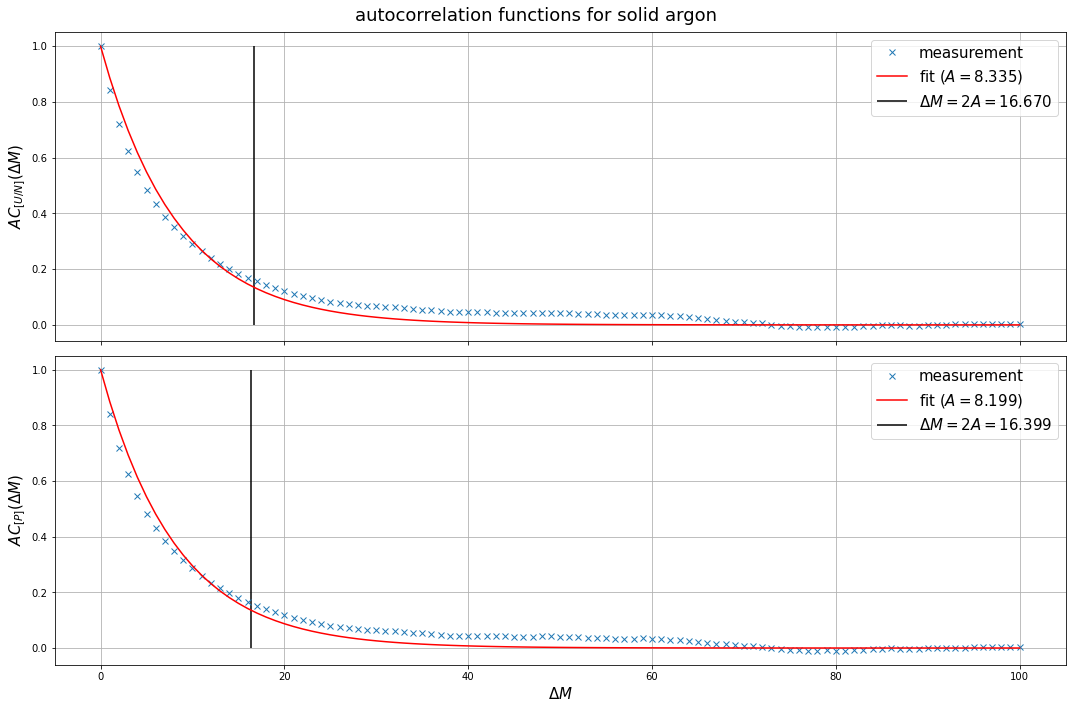

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy import constants as const

def LJ_to_SI(vals, measure, eps, sigma):
    """
    Convert measures from LJ units to SI units.
    Returns:
    * temperature in K
    * potential energy in meV
    * pressure in MPa
    * length in nm
    """
    if measure == "temp": 
        return vals * (eps / const.k)
    if measure in "epot":
        return vals * eps / const.e * 10**3
    if measure == "pres":
        return vals * eps / sigma**3 * 10**(-6)
    if measure == "length":
        return vals * sigma * 10**9
    
def fit_autocor(delta_M, A):
    return np.exp(-delta_M / A)

def plot_autocorrelation(nlags, directory, title):
    """
    Plot the autocorrelation function for potential energy and pressure in given directory.
    """
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    ax[1].set_xlabel(r"$\Delta M$", size=15)
    
    measure_list = ["epot", "pres"]
    ylabel_list = [r"$AC_{[U/N]}(\Delta M)$", r"$AC_{[P]}(\Delta M)$"]
    
    delta_M = np.arange(0, nlags + 1)
    
    for i, measure in enumerate(measure_list):
        vals = np.loadtxt(directory + "/inst." + measure + ".0")
        
        autocor = sm.tsa.acf(vals, fft=False, nlags=nlags)
        A, sigma_A = curve_fit(fit_autocor, delta_M, autocor)
        
        ax[i].plot(delta_M, autocor, label="measurement", marker="x", linestyle="None")
        ax[i].plot(delta_M, fit_autocor(delta_M, A), color="r", label="fit ($A={:.3f}$)".format(A[0]))
        ax[i].vlines(2*A, 0, 1, color="k", label=r"$\Delta M = 2A = {:.3f}$".format(2 * A[0]))
        
        ax[i].set_ylabel(ylabel_list[i], size=15)
        ax[i].grid()
        ax[i].legend(fontsize=15)
    
    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()
    
# overall parameters of argon
eps = 120 * const.k # in Joule
sigma = 0.34 * 10**(-9) # in m

plot_autocorrelation(100, "data/solid/inst", "autocorrelation functions for solid argon") 

Another perspective on the blocking method gives a plot of the uncertainty against the number of measurements $L$ in each block, as in the next figure. We observe that the uncertainty estimation saturates completely at at about $L = 2500$. For such a value, it is guaranteed the the blocking method does not underestimate the uncertainty.

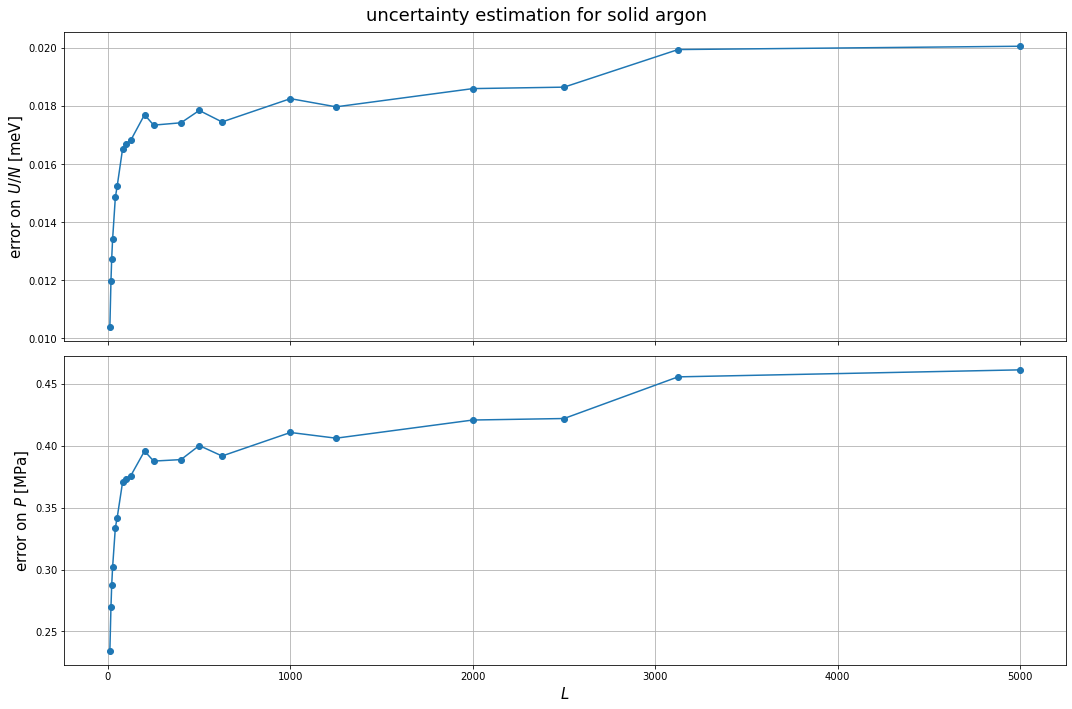

In [71]:
def find_divisors(a, lower, upper):
    """
    Returns all devisors of a larger than lower and smaller than upper.
    """
    
    divisors = []
    for i in range(lower, upper+1):
        if a%i == 0:
            divisors.append(i)
    
    return divisors

def error(AV, AV2, n):
    if n==0:
        return 0
    else:
        return np.sqrt((AV2 - AV**2)/(n-1))
                       
def blocking(vals, L):
    """
    Computes mean and standard error of vals using blocking method with L measurements per block
    """
    
    N = int(len(vals) / L)
    
    ave = 0
    ave2 = 0
    
    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += vals[k]
        ave += sum/L       
        ave2 += (sum/L)**2 
    
    ave /= N
    ave2 /= N
    err = error(ave, ave2, N) # Statistical uncertainty

    return (ave, err)

def plot_uncertainty(directory, title, L, eps, sigma):
    """
    Plot the estimated uncertainty for potential energy and pressure in given directory
    as a function of the number of measurements L in each block.
    """
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    ax[1].set_xlabel("$L$", size=15)
    
    measure_list = ["epot", "pres"]
    ylabel_list = ["error on $U/N$ [meV]", "error on $P$ [MPa]"]

    for i, measure in enumerate(measure_list):
        vals = np.loadtxt(directory + "/inst." + measure + ".0")
        vals = LJ_to_SI(vals, measure, eps, sigma)
        
        err = []
        for j in range(len(L)):
            L_j = L[j]
            ave_j, err_j = blocking(vals, L_j)
            err.append(err_j)
        
        ax[i].plot(L, err, marker="o")
        
        ax[i].set_ylabel(ylabel_list[i], size=15)
        ax[i].grid()
    
    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()
    
M = 50000
lower = 10
upper = 5000

L = find_divisors(M, lower, upper)
# L = np.arange(10, upper, 100)
plot_uncertainty("data/solid/inst", "uncertainty estimation for solid argon", L, eps, sigma)

Finally, we are able to compare the simulations of solid argon in a microcanonical and canonical ensemble. To do so, we first introduce the radial distribution function $g$ that describes the probability to find a particle a distance $r$ apart from a reference particle with respect to an ideal gas. The radial distribution function for solid argon calculated from $N_{max}=100$ blocks each containing $L=2500$ measurements can be found below. We observe an excellent agreement between both ensembles, also considering the barely visible uncertainties. From this point of view, both ensembles simulate the same system and we expect comparable results for the thermodynmic outcomes.

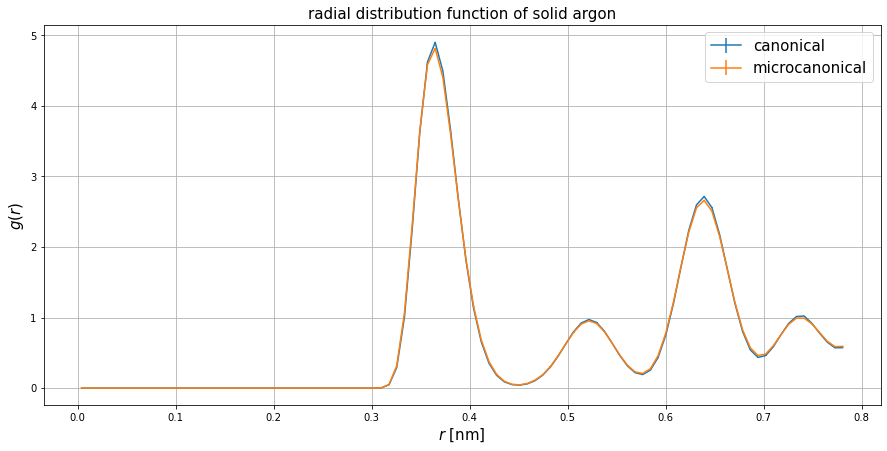

In [69]:
def plot_gofr(directory, title, eps, sigma):
    """
    Plot histogram of g(r) for molecular dynamics and Metropolis simulation.
    """
    
    plt.figure(figsize=(15, 7))
    
    file_list = ["/metro/output.gave.0", "/moldyn/ave_gofr.0"]
    label = ["canonical", "microcanonical"]
    
    for i, file in enumerate(file_list):
        r, gofr, gofr_err = np.loadtxt(directory + file, skiprows=1, delimiter=",", unpack=True)
        r = LJ_to_SI(r, "length", eps, sigma)
        
        plt.errorbar(r, gofr, gofr_err, label=label[i])
    
    plt.xlabel("$r$ [nm]", size=15)
    plt.ylabel("$g(r)$", size=15)
    plt.title(title, size=15)
    plt.grid()
    plt.legend(fontsize=15)
    plt.show()

plot_gofr("data/solid", "radial distribution function of solid argon", eps, sigma)

As we can see in the next figure, the progressive mean of the energy per particle $U/N$ and the pressure $P$ as a function of the number of steps $M$ (with $N_{max}=100$ blocks each containing $L=2500$ measurements) of both ensembles are indeed close. In terms of the uncertainties, one could conclude that the predictions for the considered thermodynamic variables are not compatible. However, the main reason for this is that - as already stated above - there is no fixed temperature $T$ in the microcanonical ensemble. Hence, we can only try to simulate a system as close as possible to the given temperature.The actual temperature may vary by several degrees Kelvin which gives us another source of uncertainty in the comparison that is not covered by the error bars computed using the blocking method. 

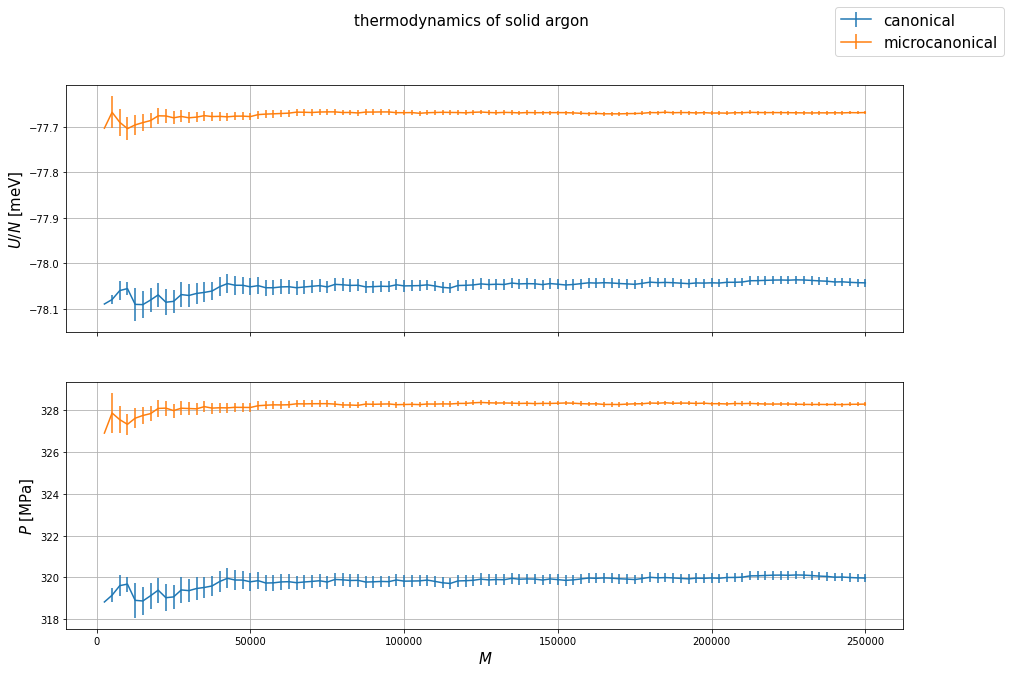

In [67]:
def plot_U_and_P(directory, title, eps, sigma):
    """
    Plot U/N and P for molecular dynamics and Metropolis simulation.
    """  
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
        
    file_list = [["/metro/output.epot.0", "/moldyn/ave_epot.out"],
                 ["/metro/output.pres.0", "/moldyn/ave_pres.out"]]
    usecols_list = [(0,2,3), (0,1,2)]
    measure_list = ["epot", "pres"]
    label_list = ["canonical", "microcanonical"]
    ylabel_list = [r"$U / N$ [meV]", r"$P$ [MPa]"]
    
    for i in range(len(file_list)): # loop over axis
        for j, file in enumerate(file_list[i]):
            M, vals, vals_err = np.loadtxt(directory + file, skiprows=1, delimiter=",", unpack=True, usecols=usecols_list[j])
            vals = LJ_to_SI(vals, measure_list[i], eps, sigma)
            vals_err = LJ_to_SI(vals_err, measure_list[i], eps, sigma)
            
            ax[i].errorbar(M, vals, vals_err, label=label_list[j] if i==0 else None)
            
        ax[i].set_ylabel(ylabel_list[i], size=15)    
        ax[i].grid()
    
    ax[1].set_xlabel("$M$", size=15)
    
    fig.suptitle(title, size=15)
    fig.legend(fontsize=15)
    
    plt.show()
    
plot_U_and_P("data/solid", "thermodynamics of solid argon", eps, sigma)

### Liquid Argon (@ T=132K)

For argon in its liquid state, we essentially repeat the procedure for the solid argon. Again, we start with the autocorrelation function computed from $M=5 \times 10^5$ measurements of the equilibrated system. The result is displayed in the figure below. From the fit, we conclude that after about $\Delta M = 17$ steps for the potential energy per particle $U/N$ and $\Delta M = 22$ for the pressure $P$ the two measurements have a negligible correlation and can be treated as independent.

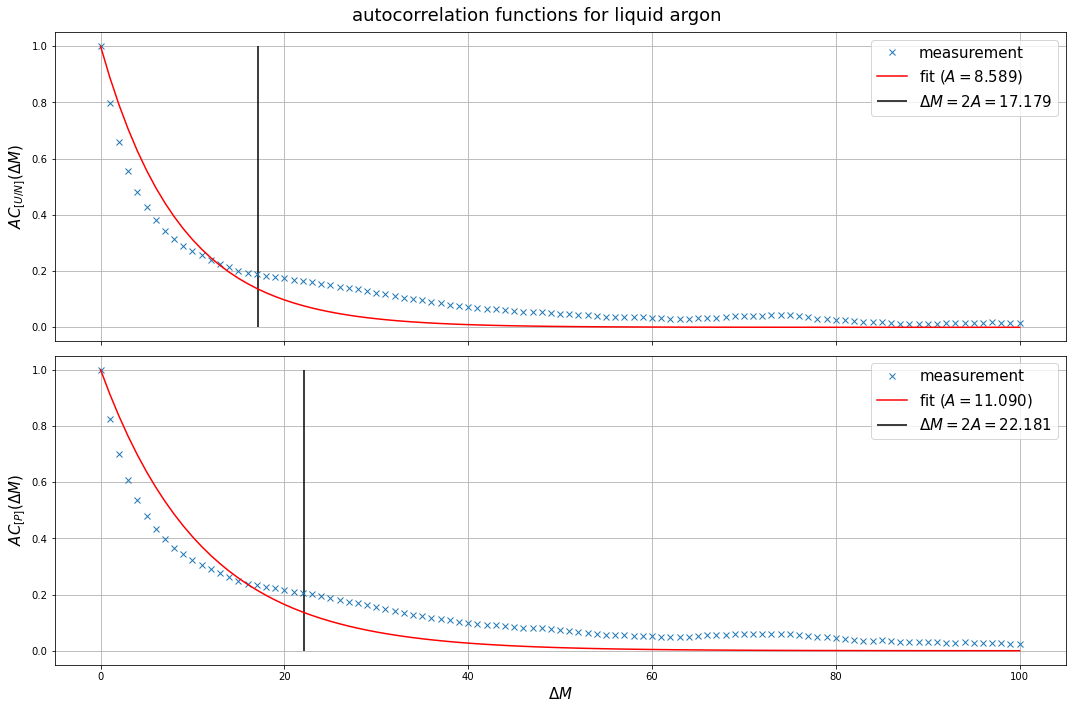

In [72]:
plot_autocorrelation(100, "data/liquid/inst", "autocorrelation functions for liquid argon") 

The uncertainty on our thermodynamic variables shows again a saturating behavior with respect to the number of measurements $L$ in each block, see the figure below. Again, $L=2500$ measurements are a good choice to prevent the underestimation of uncertainties.

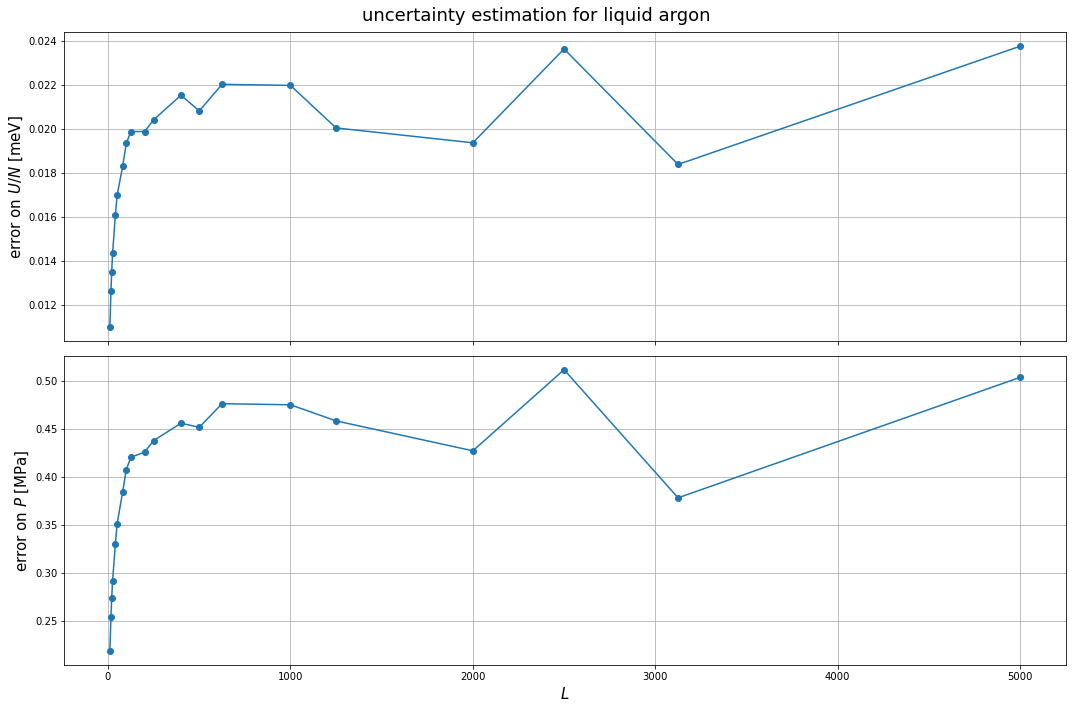

In [75]:
plot_uncertainty("data/liquid/inst", "uncertainty estimation for liquid argon", L, eps, sigma)

The next figure shows that the radial distribution function $g$ as a function of the radial distance $r$ for the liquid argon are indistinguishable for both ensembles. Again, we used $N_{max} = 100$ blocks, each with $L=2500$ measurements.

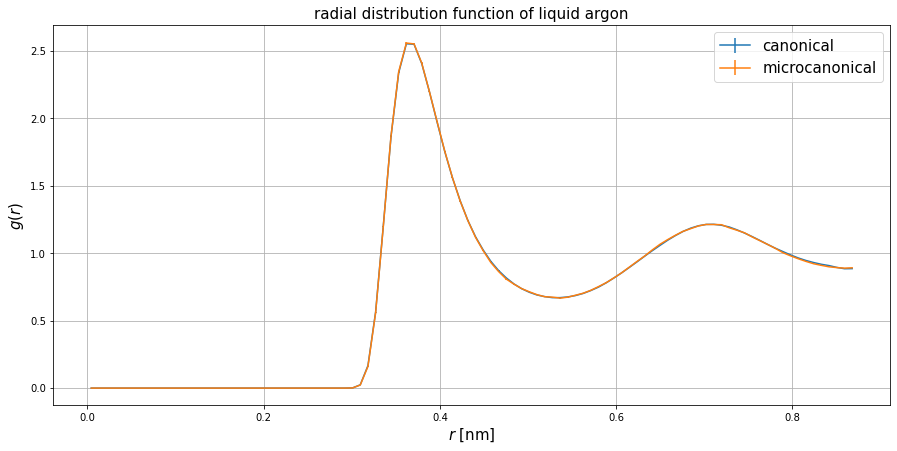

In [73]:
plot_gofr("data/liquid", "radial distribution function of liquid argon", eps, sigma)

In the figure below, we visualize the progressive means of the potential energy per particle $U / N$  and the pressure $P$ for the simulation of liquid argon as a function of the number of steps $M$. We observe an excellent agreement between both ensembles. However, note that the main source of uncertainty in this comparison is not given by the errrorbars from the blocking method but from the temperature calibration in the microcanonical ensemble.

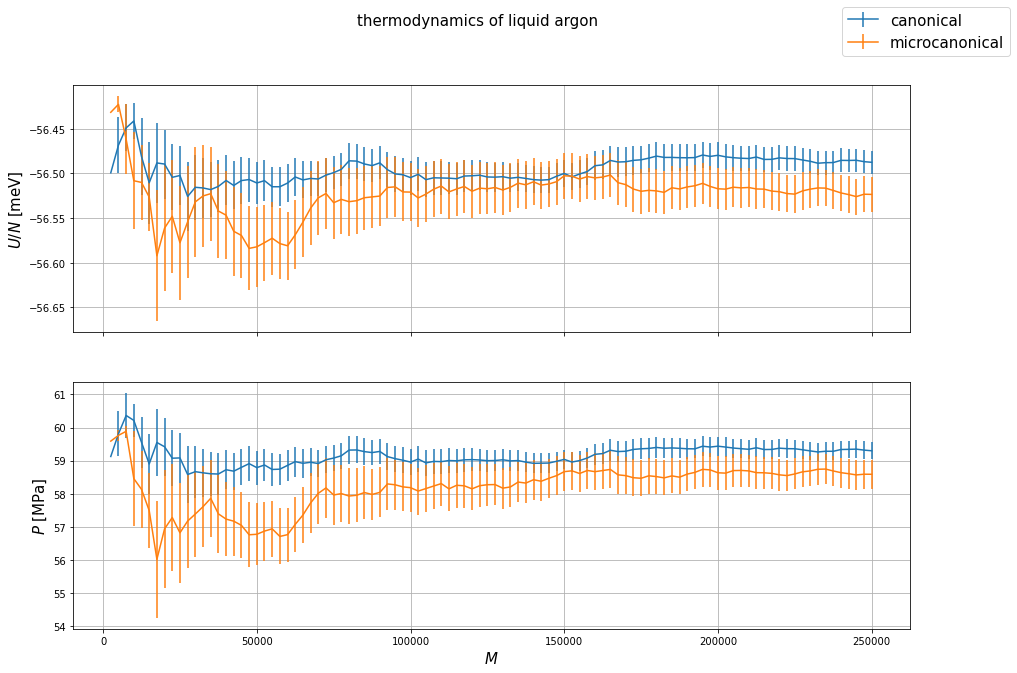

In [76]:
plot_U_and_P("data/liquid", "thermodynamics of liquid argon", eps, sigma)

### Gaseous Argon (@ T=144K)

Finally, we repeat the same procedure as before to compute the autocorrelation function $AC$ as a function of the lag $\Delta M$ from a simulation of the canonical ensemble of gaseous argon. The result for both observables of interest is plotted below. As we can conclude from the fit, the correlation is negligible after a lag of $\Delta M = 6$ and $\Delta M = 2$, respectively.

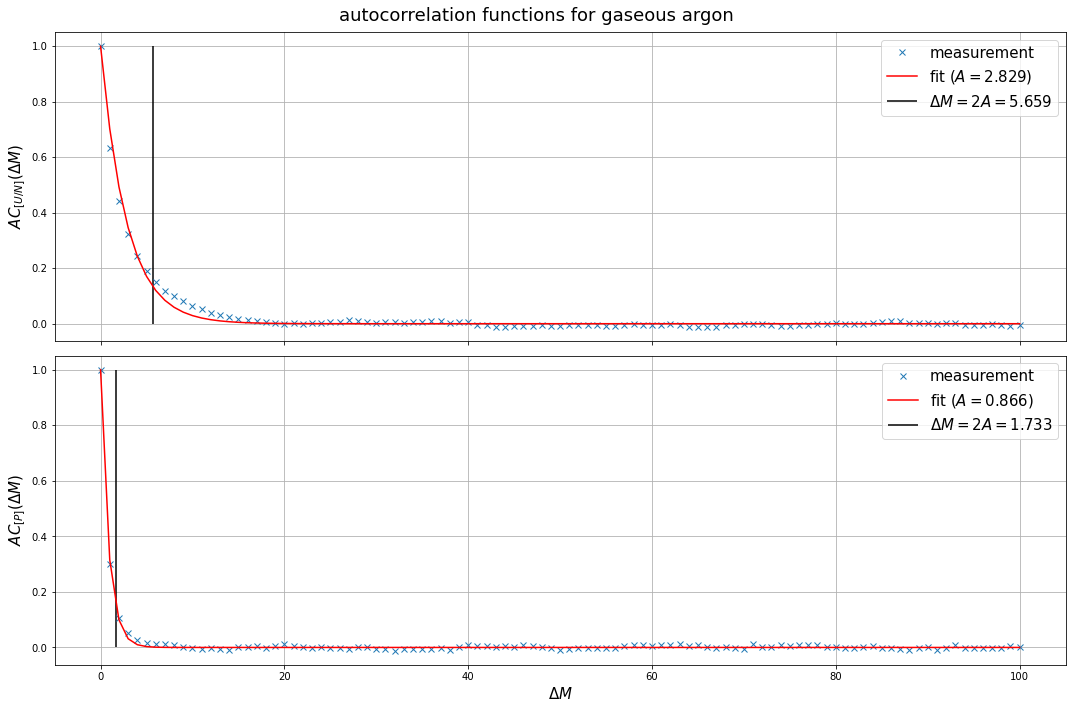

In [77]:
plot_autocorrelation(100, "data/gaseous/inst", "autocorrelation functions for gaseous argon") 

The next figure illustrates the dependency of the uncertainty of the potential energy per particle $U/N$ and the pressure $P$ as a function of the number of measurements $L$ per block for our simulation of gaseous argon. Again, $L=2500$ is a good choice to reduce the risk of underestimating the uncertainty on the thermodynamical quantities of interest.

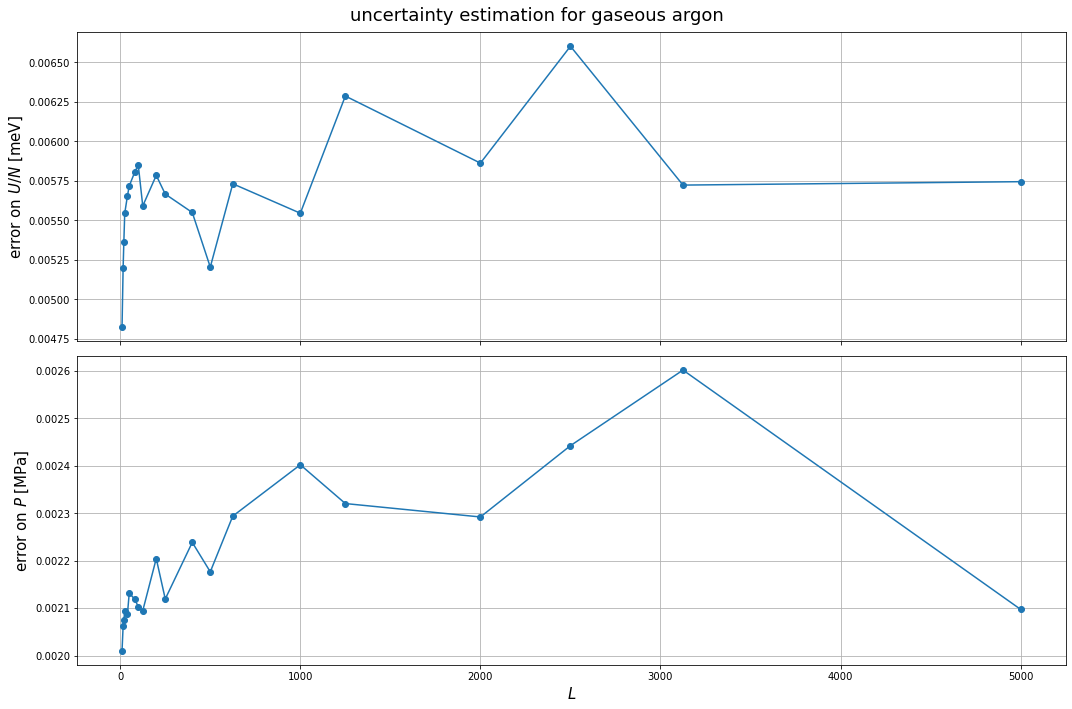

In [78]:
plot_uncertainty("data/gaseous/inst", "uncertainty estimation for gaseous argon", L, eps, sigma)

In the figure below, we observe again an excellent agreement of the radial distribution functions $g$ for both ensembles as a function of the radius $r$.

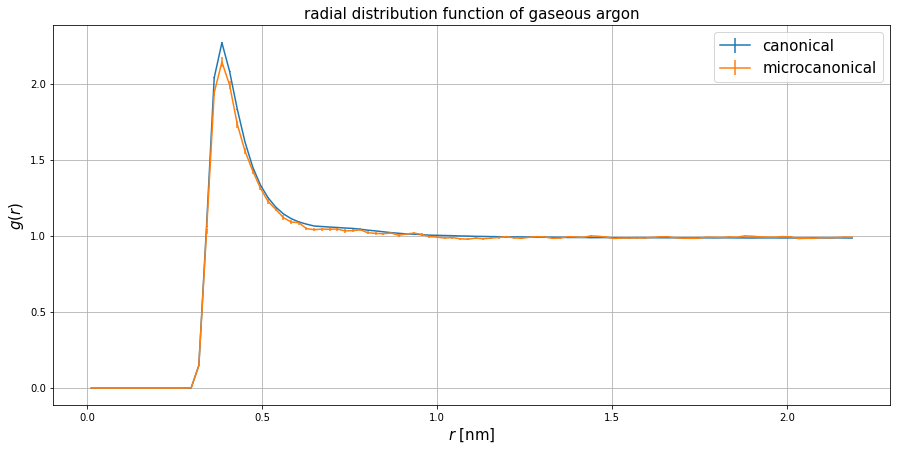

In [81]:
plot_gofr("data/gaseous", "radial distribution function of gaseous argon", eps, sigma)

The last figure below shows the progressive mean of the potential energy per particle $U/N$ and the pressure $P$ as a function of the number of steps $M$. Again, we observe an agreement between both ensembles, given the already discussed sources of uncertainty. 

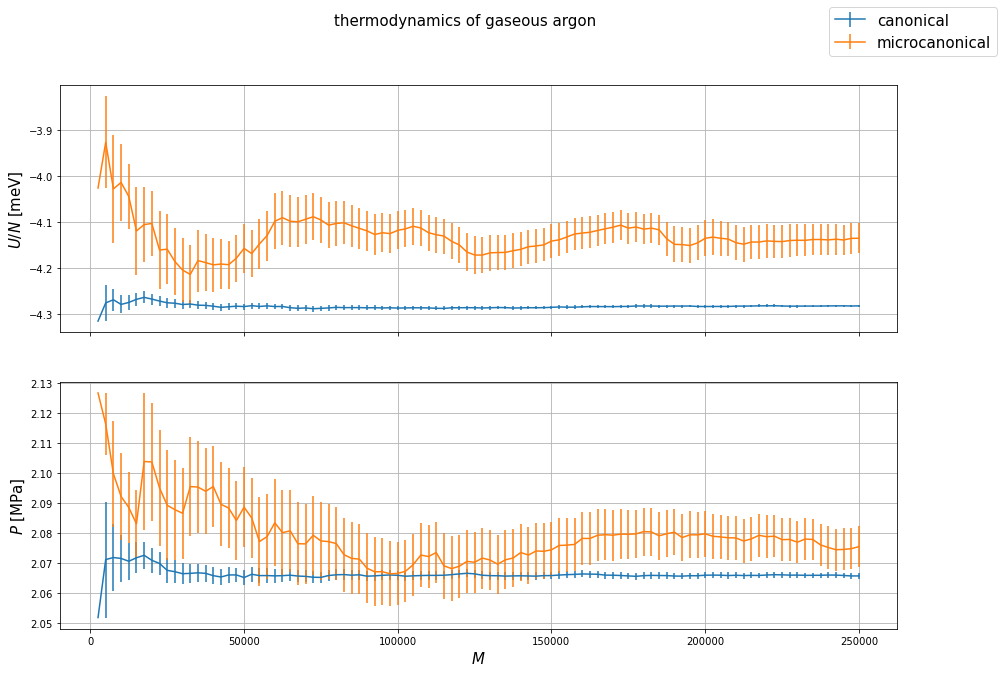

In [83]:
plot_U_and_P("data/gaseous", "thermodynamics of gaseous argon", eps, sigma)